
Train a classifier on hand-made custom features

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys

root_path = os.path.abspath("..")
if root_path not in sys.path:
    sys.path.append(root_path)
    
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from common.dataflow import get_train_df, get_test_df, get_image, get_target, get_inc_angle
from common.dataflow_visu_utils import display_image

In [3]:
train_df = get_train_df()
train_ships_df = train_df[train_df['is_iceberg'] == 0]
train_icebergs_df = train_df[train_df['is_iceberg'] == 1]

Create features and train gradient boosted trees 

In [4]:
from common.imgproc_utils import *

In [5]:
def compute_mins_means_maxs(img):
    assert len(img.shape) == 3 and img.shape[2] == 2
    mins = [0.0, 0.0]
    maxs = [0.0, 0.0]
    means = [0.0, 0.0]
    for i in range(2):
        b = img[:, :, i]
        mins[i] = np.min(b)
        maxs[i] = np.max(b)
        means[i] = np.mean(b)  
    return mins, means, maxs


def count_and_mean_positive_signal(img):
    assert len(img.shape) == 3 and img.shape[2] == 2
    out = [0.0, 0.0]
    count = [0, 0]
    for i in range(2):
        b = img[:, :, i]
        b = b[b > 0]
        out[i] = np.mean(b) if len(b) > 0 else 0.0
        count[i] = len(b)
    return (*out, *count)


# def compute_features(img, a):  
#     mins, means, maxs = compute_mins_means_maxs(img)
#     ret = count_and_mean_positive_signal(img)    
#     obj_per_band = segment_object_per_band(img[:, :, :2])
#     obj_size_per_band = np.count_nonzero(obj_per_band[:, :, 0]), np.count_nonzero(obj_per_band[:, :, 1])
#     obj_size = object_size(img[:, :, :2])
    
#     return (*means, *maxs, *ret, obj_size, *obj_size_per_band, a)


#     img = np.concatenate([img, 
#                           np.expand_dims(img[:, :, 0] + img[:, :, 1], axis=-1)], 
#                          axis=-1)    


def compute_features(img, a):  
    mins, means, maxs = compute_mins_means_maxs(img)
    ret = count_and_mean_positive_signal(img)    
    obj_per_band = segment_object_per_band(img[:, :, :2])
    obj_size_per_band = np.count_nonzero(obj_per_band[:, :, 0]), np.count_nonzero(obj_per_band[:, :, 1])
    obj_size = object_size(img[:, :, :2])    
    return (*means, *maxs, *ret, obj_size, *obj_size_per_band, a)
#     return (*means, *maxs, a)
# #     return (*ret, obj_size, a)

In [6]:
def norm_b1(b, a):
    return 0.5 * (b + (0.455748230884 * (a - 2*30) - 3.3218050865))


def norm_b2(b, a):
    return 0.5 * (b + (0.280327982183 * (a - 2*30) - 15.6226798323))


def norm_inc_angle(x, a):
    x[:, :, 0] = norm_b1(x[:, :, 0], a)
    x[:, :, 1] = norm_b2(x[:, :, 1], a)
    return x

In [15]:
def random_crop(img, size):
    h, w, _ = img.shape
    th, tw = size, size
    if w == tw and h == th:
         params = (0, 0, h, w)
    else:
        i = np.random.randint(0, h - th)
        j = np.random.randint(0, w - tw)
        params =(i, j, th, tw)    
    i, j, h, w = params
    return img[i:i + h, j:j + w, :]    


def center_crop(img, size):
    h, w, _ = img.shape
    th, tw = size, size
    if w == tw and h == th:
        params = (0, 0, h, w)
    else:
        i = (h - th) // 2
        j = (w - tw) // 2
        params = (i, j, th, tw)
    i, j, h, w = params
    return img[i:i + h, j:j + w, :]

(-17.870424,
 -23.815344,
 -5.2458105,
 -13.399006,
 0.0,
 0.0,
 0,
 0,
 99,
 191,
 147,
 31.3432)

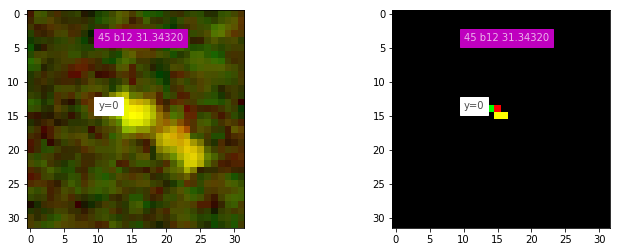

In [55]:
index = train_df.index[45]
img = get_image(index, train_df)
a = get_inc_angle(index, train_df)
y = get_target(index, train_df)

img = norm_inc_angle(img, a) 

plt.figure(figsize=(12, 4))
ax = plt.subplot(121)
display_image(ax, center_crop(img, size=32), index, 'b12', a, target=y)
ax = plt.subplot(122)
display_image(ax, segment_object_per_band(center_crop(img, size=32)), index, 'b12', a, target=y)

compute_features(img, a)

In [10]:
train_df.loc[train_df.index[55], :]

band_1        [-20.080898, -21.047037, -22.329433, -23.60285...
band_2        [-25.371161999999998, -27.239639, -30.589506, ...
id                                                     28de1d17
inc_angle                                               42.5376
is_iceberg                                                    0
Name: 55, dtype: object

Prepare data

In [21]:
import cv2

In [22]:
def random_affine(img, scale=(0.8, 1.2), translation=(0.2, 0.2)):
    h, w, c = img.shape    
    s = np.random.uniform(scale[0], scale[1])
    tx = np.round(np.random.uniform(-translation[0]*w, translation[0]*w))
    ty = np.round(np.random.uniform(-translation[1]*h, translation[1]*h))
    center = (img.shape[1::-1] * np.array((0.5, 0.5))) - 0.5
    transform_matrix = cv2.getRotationMatrix2D(tuple(center), 0.0, s)     
    # Apply shift :
    transform_matrix[0, 2] += tx
    transform_matrix[1, 2] += ty
    ret = cv2.warpAffine(img, transform_matrix, img.shape[1::-1],
                         flags=1,
                         borderMode=cv2.BORDER_REPLICATE)
    return ret

(-13.974339,
 -23.547983,
 -5.2122684,
 -20.377745,
 0.0,
 0.0,
 0,
 0,
 2,
 399,
 23,
 42.537599999999998)

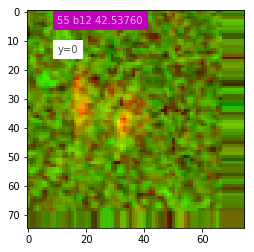

In [23]:
index = train_df.index[55]
img = get_image(index, train_df)
a = get_inc_angle(index, train_df)
y = get_target(index, train_df)

img = norm_inc_angle(img, a) 

plt.figure(figsize=(12, 4))
ax = plt.subplot(111)
display_image(ax, random_affine(img), index, 'b12', a, target=y)

n_features = len(compute_features(img, a))
compute_features(img, a)

In [36]:
n_data_augs = 1

features = np.zeros((len(train_df) * n_data_augs, n_features))
targets = np.zeros((len(train_df) * n_data_augs, ), dtype=int)
for i, index in enumerate(train_df.index):
    img = get_image(index, train_df)
    a = get_inc_angle(index, train_df)
    t = get_target(index, train_df)
    
    img = norm_inc_angle(img, a)
    
    features[n_data_augs*i, :] = compute_features(center_crop(img, 32), a)
    targets[n_data_augs*i] = t        
    
    if n_data_augs > 1:
        img_aug = random_affine(img)
        features[n_data_augs*i + 1, :] = compute_features(center_crop(img_aug, 32), a)
        targets[n_data_augs*i + 1] = t    

        img_aug = random_affine(img)
        features[n_data_augs*i + 2, :] = compute_features(center_crop(img_aug, 32), a)
        targets[n_data_augs*i + 2] = t    


# indices = list(range(len(features)))
# np.random.shuffle(indices)
# features = features[indices, :]
# targets = targets[indices]

In [25]:
features[:10, :]

array([[ -1.86917992e+01,  -2.47599030e+01,  -5.43080425e+00,
         -1.56907072e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          3.00000000e+00,   6.00000000e+00,   4.39239000e+01],
       [ -1.93291092e+01,  -2.49768944e+01,  -5.76984930e+00,
         -1.59160643e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   4.50000000e+01,
          2.61000000e+02,   5.60000000e+01,   4.39239000e+01],
       [ -1.27331438e+01,  -2.28396606e+01,  -3.53334904e-01,
         -1.08510284e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   4.00000000e+00,
          5.00000000e+00,   4.00000000e+00,   3.81562000e+01],
       [ -1.32915277e+01,  -2.35552578e+01,  -4.40901816e-01,
         -1.13546286e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   8.40000000e+01,
          4.63000000e+02,   4.38000000e+02,   3.81562000e+01],
    

In [37]:
import xgboost as xgb

In [38]:
dtrainval = xgb.DMatrix(features, label=targets)

Boosting

In [39]:
seed = 12345
n_folds = 5

params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "logloss",
    "eta": None,
    "tree_method": 'auto',
    "max_depth": None,
    "subsample": None,
    "colsample_bytree": None,
    "silent": 1,
    "seed": None,
}

best_params = {
    'test-%s-mean' % params['eval_metric']: 1e10,
    'params': {},
    'num_boost_round': 0
}

# Search for the best parameters using CV
def generate_params():
    eta = np.random.uniform(0.05, 0.001)
    max_depth = np.random.randint(2, 4)
    subsample = np.random.uniform(0.5, 0.95)
    colsample_bytree = np.random.uniform(0.5, 0.95)
    return eta, max_depth, subsample, colsample_bytree

In [41]:
np.random.seed(seed)
for i in range(100):

    eta, max_depth, subsample, colsample_bytree = generate_params()
    i += 1
    seed += i
    print('\n{} : XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'
          .format(i, eta, max_depth, subsample, colsample_bytree))
    num_boost_round = 20000
    early_stopping_rounds = 500

    params['eta'] = eta
    params['max_depth'] = max_depth
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample_bytree
    params['seed'] = seed

    cvresult = xgb.cv(params, dtrain=dtrainval,
                      seed=params['seed'],
                      num_boost_round=num_boost_round,
                      early_stopping_rounds=early_stopping_rounds,
                      nfold=n_folds,
                      stratified=True,
                      verbose_eval=early_stopping_rounds)

    min_test_eval_metric_mean = cvresult['test-%s-mean' % params['eval_metric']].min()
    if best_params['test-%s-mean' % params['eval_metric']] > min_test_eval_metric_mean:
        best_params['test-%s-mean' % params['eval_metric']] = min_test_eval_metric_mean
        best_params['train-%s-mean' % params['eval_metric']] = cvresult['train-%s-mean' % params['eval_metric']].min()
        best_params['params'] = params
        best_params['num_boost_round'] = len(cvresult)
        print("Best cv result: ", cvresult.loc[cvresult.index[-1], :])
        print("Best params: ", params)


1 : XGBoost params. ETA: 0.004448811451959758, MAX_DEPTH: 3, SUBSAMPLE: 0.5588182828036209, COLSAMPLE_BY_TREE: 0.5178917731497594
[0]	train-logloss:0.692102+0.0002435	test-logloss:0.69222+0.000214771
[500]	train-logloss:0.460719+0.00505283	test-logloss:0.489269+0.0133318
[1000]	train-logloss:0.386838+0.00498942	test-logloss:0.434097+0.0170019
[1500]	train-logloss:0.340069+0.00542865	test-logloss:0.403916+0.0179596
[2000]	train-logloss:0.305431+0.00512324	test-logloss:0.384392+0.0192451
[2500]	train-logloss:0.277477+0.00480831	test-logloss:0.370119+0.0201115
[3000]	train-logloss:0.254368+0.00472547	test-logloss:0.359219+0.0200877
[3500]	train-logloss:0.234689+0.00443853	test-logloss:0.351044+0.0205576
[4000]	train-logloss:0.217353+0.00414557	test-logloss:0.343706+0.0205697
[4500]	train-logloss:0.202393+0.00387556	test-logloss:0.338545+0.0206333
[5000]	train-logloss:0.189045+0.00359416	test-logloss:0.334008+0.020891
[5500]	train-logloss:0.177199+0.003393	test-logloss:0.330259+0.0208116


[500]	train-logloss:0.357865+0.00314784	test-logloss:0.409687+0.0112297
[1000]	train-logloss:0.280197+0.00488657	test-logloss:0.365338+0.016186
[1500]	train-logloss:0.228171+0.00492737	test-logloss:0.337104+0.0196834
[2000]	train-logloss:0.191201+0.00415994	test-logloss:0.318324+0.0228325
[2500]	train-logloss:0.163403+0.00363664	test-logloss:0.305981+0.0248703
[3000]	train-logloss:0.141467+0.00359883	test-logloss:0.297279+0.0251247
[3500]	train-logloss:0.123595+0.00316658	test-logloss:0.291356+0.0263569
[4000]	train-logloss:0.109018+0.00294705	test-logloss:0.287314+0.0258634
[4500]	train-logloss:0.0967348+0.0027081	test-logloss:0.284648+0.0263439
[5000]	train-logloss:0.0863824+0.00239041	test-logloss:0.282695+0.0268895
[5500]	train-logloss:0.077457+0.0020681	test-logloss:0.28168+0.0272469
[6000]	train-logloss:0.0700704+0.00185752	test-logloss:0.281162+0.0278314
Best cv result:  test-logloss-mean     0.280777
test-logloss-std      0.027194
train-logloss-mean    0.072164
train-logloss-st

[13500]	train-logloss:0.093768+0.00224806	test-logloss:0.303483+0.037476
[14000]	train-logloss:0.0904248+0.00225593	test-logloss:0.302942+0.0374494
[14500]	train-logloss:0.0872184+0.0021559	test-logloss:0.302835+0.0376641
[15000]	train-logloss:0.0841806+0.00212216	test-logloss:0.302534+0.0376598

17 : XGBoost params. ETA: 0.03692879677875871, MAX_DEPTH: 3, SUBSAMPLE: 0.5861247256427625, COLSAMPLE_BY_TREE: 0.5200989204149742
[0]	train-logloss:0.685699+0.00139853	test-logloss:0.68609+0.00167557
[500]	train-logloss:0.210639+0.0034597	test-logloss:0.340341+0.0194816
[1000]	train-logloss:0.126448+0.00249769	test-logloss:0.316581+0.0185776
[1500]	train-logloss:0.0837024+0.00215562	test-logloss:0.31555+0.0184261

18 : XGBoost params. ETA: 0.03525782920339618, MAX_DEPTH: 3, SUBSAMPLE: 0.7898624683063074, COLSAMPLE_BY_TREE: 0.6249468550357634
[0]	train-logloss:0.68432+0.00273936	test-logloss:0.684857+0.00258477
[500]	train-logloss:0.207361+0.00355479	test-logloss:0.325373+0.015271
[1000]	train-

[500]	train-logloss:0.449129+0.00753454	test-logloss:0.47689+0.0240543
[1000]	train-logloss:0.379384+0.00848177	test-logloss:0.424813+0.0266272
[1500]	train-logloss:0.33662+0.00809836	test-logloss:0.398354+0.0293116
[2000]	train-logloss:0.304601+0.00773358	test-logloss:0.379619+0.0289738
[2500]	train-logloss:0.278984+0.0071694	test-logloss:0.365392+0.030459
[3000]	train-logloss:0.257765+0.00675509	test-logloss:0.354844+0.0305342
[3500]	train-logloss:0.239743+0.00663191	test-logloss:0.34641+0.0302433
[4000]	train-logloss:0.224266+0.00630583	test-logloss:0.339927+0.0308756
[4500]	train-logloss:0.210485+0.00599627	test-logloss:0.334344+0.0312673
[5000]	train-logloss:0.198366+0.00583229	test-logloss:0.33057+0.0319926
[5500]	train-logloss:0.187452+0.00571226	test-logloss:0.326938+0.0318941
[6000]	train-logloss:0.177554+0.00561782	test-logloss:0.323797+0.0319167
[6500]	train-logloss:0.168551+0.00541729	test-logloss:0.321238+0.0319056
[7000]	train-logloss:0.160321+0.00529507	test-logloss:0.31

[3000]	train-logloss:0.182673+0.00456122	test-logloss:0.327946+0.0213645
[3500]	train-logloss:0.162608+0.00449697	test-logloss:0.321012+0.0236183
[4000]	train-logloss:0.145675+0.00409208	test-logloss:0.315779+0.0255412
[4500]	train-logloss:0.131445+0.00404426	test-logloss:0.312179+0.0271525
[5000]	train-logloss:0.118936+0.00399657	test-logloss:0.308851+0.0282252
[5500]	train-logloss:0.108268+0.00382051	test-logloss:0.306641+0.0296206
[6000]	train-logloss:0.0988914+0.00366538	test-logloss:0.305736+0.0311282
[6500]	train-logloss:0.0905498+0.00345644	test-logloss:0.304978+0.0322403
[7000]	train-logloss:0.083289+0.00325401	test-logloss:0.305263+0.0337055

34 : XGBoost params. ETA: 0.004964983469801815, MAX_DEPTH: 2, SUBSAMPLE: 0.5481380495310487, COLSAMPLE_BY_TREE: 0.5735883735533085
[0]	train-logloss:0.692202+0.000174353	test-logloss:0.692277+0.000178596
[500]	train-logloss:0.504667+0.00571622	test-logloss:0.522519+0.0113858
[1000]	train-logloss:0.436361+0.00774493	test-logloss:0.468+0.02

[2500]	train-logloss:0.115761+0.00379111	test-logloss:0.300649+0.0385704
[3000]	train-logloss:0.0959596+0.00341612	test-logloss:0.297909+0.0409799
[3500]	train-logloss:0.080724+0.002965	test-logloss:0.296927+0.0437237
[4000]	train-logloss:0.0687654+0.00264685	test-logloss:0.297491+0.045468

41 : XGBoost params. ETA: 0.0059171164992787365, MAX_DEPTH: 2, SUBSAMPLE: 0.8879452805127539, COLSAMPLE_BY_TREE: 0.7439131398189897
[0]	train-logloss:0.691691+0.000132211	test-logloss:0.691782+0.000148261
[500]	train-logloss:0.485565+0.0026002	test-logloss:0.505786+0.0127272
[1000]	train-logloss:0.416383+0.00359307	test-logloss:0.449028+0.016999
[1500]	train-logloss:0.37676+0.0043752	test-logloss:0.419113+0.0191652
[2000]	train-logloss:0.348389+0.0051955	test-logloss:0.400991+0.0206688
[2500]	train-logloss:0.323917+0.00528475	test-logloss:0.386608+0.0220229
[3000]	train-logloss:0.302096+0.00489671	test-logloss:0.374205+0.0236745
[3500]	train-logloss:0.283342+0.00488799	test-logloss:0.364271+0.025167

[2000]	train-logloss:0.114337+0.0037055	test-logloss:0.306107+0.0297351
[2500]	train-logloss:0.0922626+0.0030042	test-logloss:0.302774+0.0302519
[3000]	train-logloss:0.0760446+0.0022797	test-logloss:0.30249+0.0305669

45 : XGBoost params. ETA: 0.02704452011308558, MAX_DEPTH: 3, SUBSAMPLE: 0.8543838191651206, COLSAMPLE_BY_TREE: 0.5203404812514404
[0]	train-logloss:0.687986+0.000818565	test-logloss:0.68829+0.000995498
[500]	train-logloss:0.250868+0.00840298	test-logloss:0.350963+0.0327351
[1000]	train-logloss:0.157129+0.00669786	test-logloss:0.305863+0.0403701
[1500]	train-logloss:0.106712+0.00591988	test-logloss:0.28636+0.042416
[2000]	train-logloss:0.0765642+0.00492805	test-logloss:0.279113+0.0467586
[2500]	train-logloss:0.0578438+0.00393945	test-logloss:0.279489+0.0502436

46 : XGBoost params. ETA: 0.020957886548049188, MAX_DEPTH: 2, SUBSAMPLE: 0.6046958115620642, COLSAMPLE_BY_TREE: 0.7231257543355079
[0]	train-logloss:0.688501+0.000693734	test-logloss:0.68882+0.000508127
[500]	train-

[6500]	train-logloss:0.2033+0.00499761	test-logloss:0.336486+0.0299592
[7000]	train-logloss:0.19452+0.00507614	test-logloss:0.333395+0.0296253
[7500]	train-logloss:0.186681+0.00490716	test-logloss:0.331134+0.0299954
[8000]	train-logloss:0.179335+0.00477182	test-logloss:0.328757+0.0297912
[8500]	train-logloss:0.172485+0.00455106	test-logloss:0.326746+0.030151
[9000]	train-logloss:0.166064+0.00445755	test-logloss:0.32524+0.0301697
[9500]	train-logloss:0.159945+0.0042755	test-logloss:0.323963+0.0305307
[10000]	train-logloss:0.154136+0.00420925	test-logloss:0.322683+0.0313496
[10500]	train-logloss:0.1489+0.0040328	test-logloss:0.321986+0.031572
[11000]	train-logloss:0.143899+0.00383065	test-logloss:0.321183+0.0313901
[11500]	train-logloss:0.139075+0.00370062	test-logloss:0.320424+0.0318916
[12000]	train-logloss:0.134564+0.00361173	test-logloss:0.319732+0.0321344
[12500]	train-logloss:0.130152+0.00358111	test-logloss:0.319338+0.032671
[13000]	train-logloss:0.126058+0.00347711	test-logloss:0

[2500]	train-logloss:0.125544+0.00255534	test-logloss:0.309283+0.0318469
[3000]	train-logloss:0.105159+0.00248662	test-logloss:0.306869+0.0332724
[3500]	train-logloss:0.0892222+0.00225594	test-logloss:0.304897+0.0350574
[4000]	train-logloss:0.0766328+0.00216738	test-logloss:0.305511+0.037275

63 : XGBoost params. ETA: 0.013951632997161914, MAX_DEPTH: 2, SUBSAMPLE: 0.805516171184138, COLSAMPLE_BY_TREE: 0.8762323918496946
[0]	train-logloss:0.689631+0.000405268	test-logloss:0.689826+0.000453732
[500]	train-logloss:0.394957+0.00547999	test-logloss:0.434188+0.0179273
[1000]	train-logloss:0.323003+0.00673993	test-logloss:0.386579+0.0233939
[1500]	train-logloss:0.273889+0.00676362	test-logloss:0.358606+0.0267941
[2000]	train-logloss:0.237781+0.007257	test-logloss:0.33981+0.0287735
[2500]	train-logloss:0.209852+0.00673085	test-logloss:0.327794+0.0311486
[3000]	train-logloss:0.18725+0.00588854	test-logloss:0.318171+0.0325869
[3500]	train-logloss:0.1684+0.0055835	test-logloss:0.311878+0.0344202


[500]	train-logloss:0.323027+0.00627353	test-logloss:0.396734+0.032504
[1000]	train-logloss:0.232378+0.00570433	test-logloss:0.351538+0.0365807
[1500]	train-logloss:0.178046+0.00382586	test-logloss:0.331676+0.0378763
[2000]	train-logloss:0.141633+0.00287814	test-logloss:0.322138+0.0393848
[2500]	train-logloss:0.115012+0.00251316	test-logloss:0.318386+0.0398614
[3000]	train-logloss:0.0951752+0.00225016	test-logloss:0.317273+0.0407312

69 : XGBoost params. ETA: 0.007869673777755735, MAX_DEPTH: 2, SUBSAMPLE: 0.7819670410238077, COLSAMPLE_BY_TREE: 0.6528034030404193
[0]	train-logloss:0.691312+0.000153554	test-logloss:0.691344+0.000199392
[500]	train-logloss:0.457687+0.00535382	test-logloss:0.483756+0.0182567
[1000]	train-logloss:0.387548+0.00615394	test-logloss:0.429035+0.0221721
[1500]	train-logloss:0.346279+0.00665259	test-logloss:0.401528+0.0246953
[2000]	train-logloss:0.314619+0.00593513	test-logloss:0.383148+0.0269549
[2500]	train-logloss:0.287999+0.00584597	test-logloss:0.368289+0.02

[15500]	train-logloss:0.0911656+0.0023929	test-logloss:0.28869+0.0262904
[16000]	train-logloss:0.0881494+0.00237115	test-logloss:0.28841+0.0262028
[16500]	train-logloss:0.085276+0.00227535	test-logloss:0.288244+0.0263913
[17000]	train-logloss:0.0825474+0.0022613	test-logloss:0.287949+0.0264269
[17500]	train-logloss:0.0799632+0.00219739	test-logloss:0.287892+0.0265332
[18000]	train-logloss:0.0774724+0.00213785	test-logloss:0.287638+0.0267409
[18500]	train-logloss:0.0750588+0.00209711	test-logloss:0.287243+0.0267155
[19000]	train-logloss:0.0727916+0.00207122	test-logloss:0.287005+0.0267518
[19500]	train-logloss:0.070661+0.00206537	test-logloss:0.286968+0.0268112

76 : XGBoost params. ETA: 0.03252397155146852, MAX_DEPTH: 2, SUBSAMPLE: 0.8194094263571388, COLSAMPLE_BY_TREE: 0.5572646989431093
[0]	train-logloss:0.684952+0.000831948	test-logloss:0.685304+0.000492539
[500]	train-logloss:0.315972+0.00319658	test-logloss:0.38577+0.0139367
[1000]	train-logloss:0.229788+0.0019339	test-logloss:0.3

[2500]	train-logloss:0.0952396+0.00367755	test-logloss:0.327797+0.043812

86 : XGBoost params. ETA: 0.04096241609396277, MAX_DEPTH: 3, SUBSAMPLE: 0.7279393870524046, COLSAMPLE_BY_TREE: 0.7438756136619067
[0]	train-logloss:0.682586+0.00116274	test-logloss:0.683582+0.000934899
[500]	train-logloss:0.183981+0.00613638	test-logloss:0.324709+0.0434511
[1000]	train-logloss:0.0995876+0.00468957	test-logloss:0.304105+0.0513444
[1500]	train-logloss:0.0616174+0.00320563	test-logloss:0.307134+0.0565085

87 : XGBoost params. ETA: 0.005176309642025111, MAX_DEPTH: 3, SUBSAMPLE: 0.8318207886028551, COLSAMPLE_BY_TREE: 0.5348439939974212
[0]	train-logloss:0.691989+0.000340262	test-logloss:0.692113+0.000218909
[500]	train-logloss:0.442625+0.011795	test-logloss:0.476499+0.0279006
[1000]	train-logloss:0.369775+0.0108894	test-logloss:0.425925+0.0361742
[1500]	train-logloss:0.322072+0.00982803	test-logloss:0.397321+0.0400176
[2000]	train-logloss:0.285397+0.00836453	test-logloss:0.377621+0.042314
[2500]	train

[9000]	train-logloss:0.103363+0.0021291	test-logloss:0.30948+0.0259004
[9500]	train-logloss:0.0980602+0.00210194	test-logloss:0.309324+0.0263401

94 : XGBoost params. ETA: 0.003853940115795755, MAX_DEPTH: 3, SUBSAMPLE: 0.8361872891531207, COLSAMPLE_BY_TREE: 0.6828367170686458
[0]	train-logloss:0.692094+6.90548e-05	test-logloss:0.69219+0.000115961
[500]	train-logloss:0.464883+0.00479257	test-logloss:0.489068+0.0106327
[1000]	train-logloss:0.395988+0.00425571	test-logloss:0.43705+0.0137308
[1500]	train-logloss:0.351245+0.00416915	test-logloss:0.408041+0.0144109
[2000]	train-logloss:0.316699+0.00404821	test-logloss:0.387446+0.0145392
[2500]	train-logloss:0.287997+0.004296	test-logloss:0.371956+0.0143026
[3000]	train-logloss:0.263136+0.00403042	test-logloss:0.358868+0.0154176
[3500]	train-logloss:0.241867+0.00393195	test-logloss:0.348211+0.0160813
[4000]	train-logloss:0.223522+0.00403398	test-logloss:0.339664+0.0163575
[4500]	train-logloss:0.207134+0.00368002	test-logloss:0.332053+0.017228

In [42]:
best_params

{'num_boost_round': 3693,
 'params': {'booster': 'gbtree',
  'colsample_bytree': 0.7465995810570147,
  'eta': 0.04954936073857804,
  'eval_metric': 'logloss',
  'max_depth': 2,
  'objective': 'binary:logistic',
  'seed': 17395,
  'silent': 1,
  'subsample': 0.8808445755479906,
  'tree_method': 'auto'},
 'test-logloss-mean': 0.2645942,
 'train-logloss-mean': 0.059678200000000001}

```
{'num_boost_round': 1199,
 'params': {'booster': 'gbtree',
  'colsample_bytree': 0.7694962178891804,
  'eta': 0.0380695624105211,
  'eval_metric': 'logloss',
  'max_depth': 2,
  'objective': 'binary:logistic',
  'seed': 12727,
  'silent': 1,
  'subsample': 0.5690285270194964,
  'tree_method': 'auto'},
 'test-logloss-mean': 0.26314800000000005}
```

```
{'num_boost_round': 4430,
 'params': {'booster': 'gbtree',
  'colsample_bytree': 0.7645486555506023,
  'eta': 0.04243490693574713,
  'eval_metric': 'logloss',
  'max_depth': 2,
  'objective': 'binary:logistic',
  'seed': 5727,
  'silent': 1,
  'subsample': 0.5434422736524103,
  'tree_method': 'auto'},
 'test-logloss-mean': 0.25865359999999998}
 ```
 
 ```
 {'num_boost_round': 5663,
 'params': {'booster': 'gbtree',
  'colsample_bytree': 0.7596692896828674,
  'eta': 0.022953801186452898,
  'eval_metric': 'logloss',
  'max_depth': 2,
  'objective': 'binary:logistic',
  'seed': 12358,
  'silent': 1,
  'subsample': 0.6795255367710319,
  'tree_method': 'auto'},
 'test-logloss-mean': 0.14508460000000001,
 'train-logloss-mean': 0.013692399999999999}
 ```
 
 ```
 {'num_boost_round': 4226,
 'params': {'booster': 'gbtree',
  'colsample_bytree': 0.7512266482289428,
  'eta': 0.04846320034529252,
  'eval_metric': 'logloss',
  'max_depth': 3,
  'objective': 'binary:logistic',
  'seed': 12400,
  'silent': 1,
  'subsample': 0.6528315133773406,
  'tree_method': 'auto'},
 'test-logloss-mean': 0.11911400000000001,
 'train-logloss-mean': 0.0095306999999999996}
 ```
 
 ```
 {'num_boost_round': 3693,
 'params': {'booster': 'gbtree',
  'colsample_bytree': 0.7465995810570147,
  'eta': 0.04954936073857804,
  'eval_metric': 'logloss',
  'max_depth': 2,
  'objective': 'binary:logistic',
  'seed': 17395,
  'silent': 1,
  'subsample': 0.8808445755479906,
  'tree_method': 'auto'},
 'test-logloss-mean': 0.2645942,
 'train-logloss-mean': 0.059678200000000001}
 ```
 
 
 6 features: (*count_and_mean_positive_signal, obj_size, a)
 ```
 {'num_boost_round': 5558,
 'params': {'booster': 'gbtree',
  'colsample_bytree': 0.7104892872438897,
  'eta': 0.01237514864069466,
  'eval_metric': 'logloss',
  'max_depth': 3,
  'objective': 'binary:logistic',
  'seed': 12810,
  'silent': 1,
  'subsample': 0.559818174476409,
  'tree_method': 'auto'},
 'test-logloss-mean': 0.23760942857142855}
 ```

Train model

In [43]:
# Train model
dtrain = xgb.DMatrix(features, label=targets)
model = xgb.train(best_params['params'],
                  dtrain,
                  num_boost_round=best_params['num_boost_round'],
                  evals=[(dtrain, 'train')], 
                  verbose_eval=500)


[0]	train-logloss:0.680139
[500]	train-logloss:0.267561
[1000]	train-logloss:0.1791
[1500]	train-logloss:0.13078
[2000]	train-logloss:0.098415
[2500]	train-logloss:0.076833
[3000]	train-logloss:0.061643
[3500]	train-logloss:0.050702


In [44]:
model.get_fscore()

{'f0': 1440,
 'f1': 1291,
 'f10': 380,
 'f11': 3712,
 'f2': 1460,
 'f3': 1369,
 'f4': 20,
 'f6': 1,
 'f8': 469,
 'f9': 554}

Make predictions

In [46]:
test_df = get_test_df()
n_tta = 5

test_features = np.zeros((len(test_df) * n_tta, n_features))
data_ids = np.empty((len(test_df) * n_tta), dtype=np.object)
for i, index in enumerate(test_df.index):
    img = get_image(index, test_df)
    a = get_inc_angle(index, test_df)
    
    img = norm_inc_angle(img, a)
    
    data_id = test_df.loc[index, 'id']
    test_features[i * n_tta, :] = compute_features(center_crop(img, 32), a)
    data_ids[i * n_tta] = data_id
    for j in range(1, n_tta):
        test_features[i * n_tta + j, :] = compute_features(center_crop(random_affine(img), 32), a)
        data_ids[i * n_tta + j] = data_id        

In [47]:
dtest = xgb.DMatrix(test_features)

In [48]:
y_probas_tta = model.predict(dtest)

In [49]:
y_probas_tta.shape, data_ids.shape

((42120,), (42120,))

In [50]:
def gmean(arr):
    return np.power(np.prod(arr), 1.0/len(arr))

In [51]:
y_probas = np.zeros((len(test_df), 1))
for i in range(len(test_df)):
    y_probas[i] = gmean(y_probas_tta[i*n_tta: (i + 1)*n_tta])

In [52]:
from common import write_submission

In [53]:
output_filename = os.path.join("..", "results", "submission__xbg_12_features_ccrop32_inc_norm_val=0.2645_no_proba_thresholds.csv")
write_submission(output_filename, y_probas)

In [41]:
output_filename = os.path.join("..", "results", "submission__xbg_12_features_inc_norm_val=0.1191_proba_thresholds_0.01_0.99.csv")
write_submission(output_filename, y_probas, proba_thresholds=[0.01, 0.99])

In [42]:
!head ../results/submission__xbg_12_features_inc_norm_val=0.1191_proba_thresholds_0.01_0.99.csv

id,is_iceberg
5941774d,0.01
4023181e,0.01956870434131125
b20200e4,0.01
e7f018bb,0.99
4371c8c3,0.018405614084307003
a8d9b1fd,0.01139441152242779
29e7727e,0.1429859274386724
92a51ffb,0.99
c769ac97,0.01


In [37]:
!head ../results/submission__xbg_12_features_inc_norm_val=0.1191_no_proba_thresholds.csv

id,is_iceberg
5941774d,0.002371097589679013
4023181e,0.01956870434131125
b20200e4,3.863974410613748e-05
e7f018bb,0.9971747712433444
4371c8c3,0.018405614084307003
a8d9b1fd,0.01139441152242779
29e7727e,0.1429859274386724
92a51ffb,0.9998197382610399
c769ac97,0.0003363958235396299


Train DNN on meta-data: `[inc_angle, b1_min, b1_mean, b1_max, b2_min, b2_mean, b2_max]`

In [8]:
def get_metadata(x, a):
    mins, means, maxs = compute_mins_means_maxs(img)
    return (*mins, *means, *maxs, a)

In [183]:
n_data_augs = 1
n_features = 12


features = np.zeros((len(train_df) * n_data_augs, n_features), dtype=np.float32)
targets = np.zeros((len(train_df) * n_data_augs, 1), dtype=np.float32)
for i, index in enumerate(train_df.index):
    img = get_image(index, train_df)
    a = get_inc_angle(index, train_df)
    t = get_target(index, train_df)    
    img = norm_inc_angle(img, a)
    
    features[n_data_augs*i, :] = compute_features(img, a)
    targets[n_data_augs*i] = t

In [184]:
features.shape, targets.shape

((1604, 12), (1604, 1))

In [185]:
import torch 
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn import Module, Linear, ReLU, Dropout, Sequential, 

from torch.optim import Adam, SGD, RMSprop
from torch.nn import BCEWithLogitsLoss
from torch.nn.init import xavier_normal
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau


from sklearn.model_selection import StratifiedKFold

In [186]:
n_splits = 5
seed = 12345
fold_index = 0

In [258]:
class SimplestModel(Module):
    
    def __init__(self):
        super(SimplestModel, self).__init__()
        
        self.metadata_features = Sequential(
            Linear(12, 50),
            ReLU(True),
            Dropout(),
            Linear(50, 50),
            ReLU(True),
            Dropout()                        
        )        
        self.final_classifier = Linear(50, 1)
        self._initialize_weights()

    def _initialize_weights(self):
            for m in self.modules():
                if isinstance(m, Linear):
                    xavier_normal(m.weight)
                    m.bias.data.zero_()
        
    def forward(self, x_metadata):
        f = self.metadata_features(x_metadata)
        y = self.final_classifier(f)
        return y

In [259]:
trainval_ds = [(f, t) for f, t in zip(features, targets)]
x_metadata, y = trainval_ds[0]

In [260]:
def get_trainval_batches(trainval_ds, fold_index, num_workers=12, batch_size=128):
    x_array = []
    y_array = []
    for i, (_, y) in enumerate(trainval_ds):
        x_array.append(i)
        y_array.append(y)

    # Stratified split:
    train_indices = None
    val_indices = None
    skf = StratifiedKFold(n_splits=n_splits, random_state=seed)
    for i, (train_indices, val_indices) in enumerate(skf.split(x_array, y_array)):
        if i == fold_index:
            break

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
        
    train_batches = DataLoader(trainval_ds,
                               batch_size=batch_size,
                               sampler=train_sampler,
                               num_workers=num_workers,
                               drop_last=True)

    val_batches = DataLoader(trainval_ds,
                             batch_size=batch_size,
                             sampler=val_sampler,
                             num_workers=num_workers,
                             drop_last=True)

    return train_batches, val_batches

In [261]:
train_batches, val_batches = get_trainval_batches(trainval_ds, fold_index=0)

In [262]:
from common.torch_common_utils.training_utils import train_one_epoch, validate, accuracy

def accuracy_logits(y_logits, y_true, to_proba_fn=torch.nn.functional.softmax):
    y_pred = to_proba_fn(y_logits).data
    return accuracy(y_pred, y_true)

In [263]:
model = SimplestModel()


# params = [
#     {"params": model.metadata_features.parameters(), "lr": 0.01},
#     {"params": model.final_classifier.parameters(), "lr": 0.01}
# ]
# optimizer = Adam(params)

params = [
    {"params": model.metadata_features.parameters(), "lr": 0.051},
    {"params": model.final_classifier.parameters(), "lr": 0.051}
]
optimizer = Adam(params)

# params = [
#     {"params": model.metadata_features.parameters(), "lr": 0.03},
#     {"params": model.final_classifier.parameters(), "lr": 0.03}
# ]
# optimizer = RMSprop(params, eps=1.0)


criterion = BCEWithLogitsLoss()


lr_schedulers = [
    ExponentialLR(optimizer, gamma=0.6),
#     ReduceLROnPlateau(optimizer, factor=0.1, mode="min", patience=10, verbose=True)
]

In [264]:
b = iter(train_batches)
batch_x_meta, batch_y = next(b)
batch_x_meta.shape, batch_y.shape

(torch.Size([128, 12]), torch.Size([128, 1]))

Process Process-61671:
Process Process-61679:
Process Process-61680:
Process Process-61669:
Traceback (most recent call last):
Process Process-61672:
Process Process-61670:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
Process Process-61676:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in ru

In [265]:
config = {
    "n_epochs": 200,
    "validate_every_epoch": 1
}

to_proba_fn = torch.nn.functional.sigmoid

In [266]:
from torch.optim.lr_scheduler import _LRScheduler
from functools import partial

for epoch in range(0, config['n_epochs']):

    for scheduler in lr_schedulers:
        if isinstance(scheduler, _LRScheduler):
            scheduler.step()

    # train for one epoch
    ret = train_one_epoch(model, train_batches, criterion, optimizer, epoch,
                          config['n_epochs'],
                          avg_metrics=[partial(accuracy_logits, to_proba_fn=to_proba_fn)])
    if ret is None:
        break
    train_loss, train_acc = ret

    # evaluate on validation set
    if (epoch + 1) % config['validate_every_epoch'] == 0:
        ret = validate(model, val_batches, criterion,
                       avg_metrics=[partial(accuracy_logits, to_proba_fn=to_proba_fn)])
        if ret is None:
            break
        val_loss, val_acc = ret

        for scheduler in lr_schedulers:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(val_loss)

Validation: 100%|##########| 2/2 [00:00<00:00, 10.43it/s, Loss: 0.6927 | accuracy_logits: 0.527]


  0%|          | 0/2 [00:00<?, ?it/s]Process Process-63661:
Process Process-63665:
Process Process-63668:
Process Process-63664:
Process Process-63666:
Process Process-63669:
Process Process-63662:
Traceback (most recent call last):
Process Process-63663:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.5/dis